# 🧠 MS Lesion Synthesis Inference Playground 🧠

In [1]:
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionInpaintPipeline, UNet2DConditionModel
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
def prepare_mask_and_masked_image(image, mask, black_mask=True, discretize_mask=True):
    image = np.array(image.convert("RGB"))
    # image = image[None].transpose(0, 3, 1, 2)
    image = image.transpose(2, 0, 1)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float32) / 255.0
    # mask = mask[None, None]
    mask = mask[None]
    if discretize_mask:
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
    else:
        mask[mask < 0.0] = 0
        mask[mask >= 1.0] = 1
    mask = torch.from_numpy(mask)

    if black_mask:
        masked_image = image * (mask < 0.5) + (mask >= 0.5) * -1 if discretize_mask else image * (1 - mask)
    else:
        masked_image = image * (mask < 0.5)

    return mask, masked_image


def generate_lesion_with_diffusion(pipe, input_image, mask_image, prompt="MS lesion in an axial FLAIR MRI brain scan.", seed=17844, device="cuda"):
    """
    Generate synthetic lesion using a diffusion model and visualize results.
    
    Args:
        pipe: The diffusion pipeline (e.g., StableDiffusionInpaintPipeline).
        input_image: PIL image (the FLAIR image with masked region).
        mask_image: PIL image (binary mask for lesion region).
        prompt: Prompt for the diffusion model.
        seed: Random seed for reproducibility.
        device: Torch device ('cuda' or 'cpu').
    """
    # Inference
    generator = torch.Generator(device=device).manual_seed(seed)
    result = pipe(
        prompt=prompt,
        image=input_image,
        mask_image=mask_image,
        num_inference_steps=25,
        generator=generator,
        guidance_scale=10.0,
    )
    output_image = result.images[0]
    
    # Compute difference image
    input_tensor = transforms.ToTensor()(input_image)
    output_tensor = transforms.ToTensor()(output_image)
    difference = torch.abs(output_tensor - input_tensor)
    difference_image = transforms.ToPILImage()(difference.cpu())

    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(input_image)
    axes[0].set_title("Input FLAIR")
    axes[1].imshow(mask_image)
    axes[1].set_title("Lesion Mask")
    axes[2].imshow(output_image)
    axes[2].set_title("Generated Output")
    axes[3].imshow(difference_image)
    axes[3].set_title("Difference")
    for ax in axes: ax.axis("off")
    plt.tight_layout()
    plt.show()

    return output_image, difference_image


In [3]:
# ---- Config ----
model_path = "../lesion-inpating-dreambooth-model-new"        # <- Replace this with your fine-tuned model folder
image_path = "./input_data/flair.png"                     # <- Path to FLAIR MRI image (PNG, JPG)
mask_path = "./input_data/mask.png"                       # <- Binary mask (same size as image)
image_path2 = "./input_data/flair2.png"                   # <- Path to FLAIR MRI image (PNG, JPG)
mask_path2 = "./input_data/mask2.png"                     # <- Binary mask (same size as image)
prompt = "lesion"                                      # <- Prompt used during training
output_path = "./output_data/lesion_output.png"           # <- Where to save the output
num_steps = 25
seed = 17844
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
image_size = 512  # Assumes model was trained at 512x512

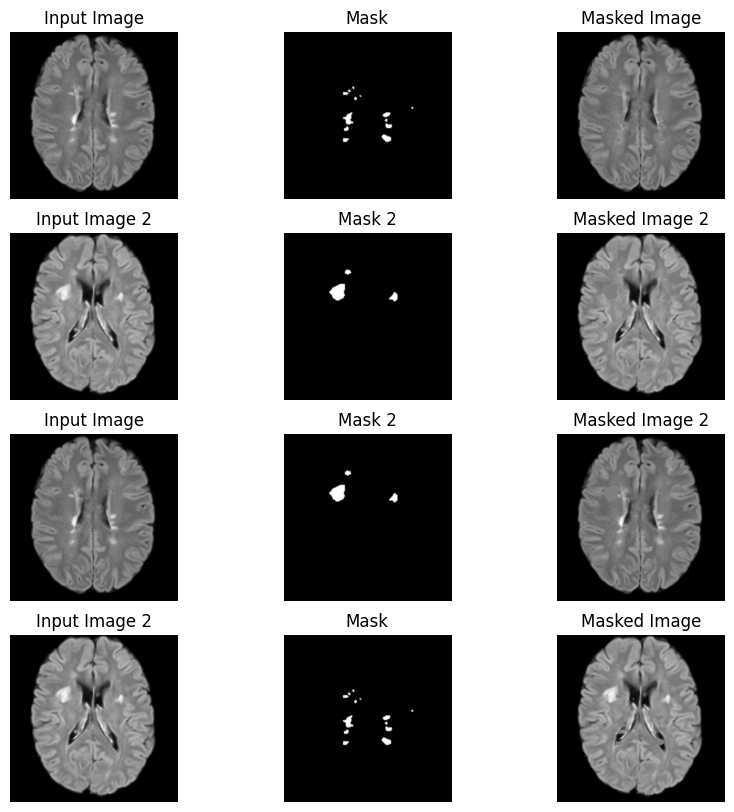

In [50]:
# ---- Load and preprocess ----
def load_image_rgb(path, size=512, mask=False):
    if mask:
        image = Image.open(path).convert("L")
    else:
        image = Image.open(path).convert("RGB")
    return transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size)
    ])(image)

input_image = load_image_rgb(image_path)
mask_image = load_image_rgb(mask_path)
input_image2 = load_image_rgb(image_path2)
mask_image2 = load_image_rgb(mask_path2)

mask, masked_image = prepare_mask_and_masked_image(input_image, mask_image, black_mask=False, discretize_mask=False)

mask2, masked_image2 = prepare_mask_and_masked_image(input_image2, mask_image2, black_mask=False, discretize_mask=False)

mask12, masked_image12 = prepare_mask_and_masked_image(input_image, mask_image2, black_mask=False, discretize_mask=False)

mask21, masked_image21 = prepare_mask_and_masked_image(input_image2, mask_image, black_mask=False, discretize_mask=False)

# unormalize
masked_image = (masked_image + 1.0) / 2.0
masked_image = transforms.ToPILImage()(masked_image.cpu())
masked_image2 = (masked_image2 + 1.0) / 2.0
masked_image2 = transforms.ToPILImage()(masked_image2.cpu())
masked_image12 = (masked_image12 + 1.0) / 2.0
masked_image12 = transforms.ToPILImage()(masked_image12.cpu())
masked_image21 = (masked_image21 + 1.0) / 2.0
masked_image21 = transforms.ToPILImage()(masked_image21.cpu())

# print(f"Loaded image of size {input_image.size}, mask of size {mask_image.size} and masked image of size {masked_image.size()}")

# plot the images
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
ax[0, 0].imshow(input_image)
ax[0, 0].set_title("Input Image")
ax[0, 0].axis("off")
ax[0, 1].imshow(mask_image, cmap="gray")
ax[0, 1].set_title("Mask")
ax[0, 1].axis("off")
ax[0, 2].imshow(masked_image)
ax[0, 2].set_title("Masked Image")
ax[0, 2].axis("off")

ax[1, 0].imshow(input_image2)
ax[1, 0].set_title("Input Image 2")
ax[1, 0].axis("off")
ax[1, 1].imshow(mask_image2, cmap="gray")
ax[1, 1].set_title("Mask 2")
ax[1, 1].axis("off")
ax[1, 2].imshow(masked_image2)
ax[1, 2].set_title("Masked Image 2")
ax[1, 2].axis("off")

ax[2, 0].imshow(input_image)
ax[2, 0].set_title("Input Image")
ax[2, 0].axis("off")
ax[2, 1].imshow(mask_image2, cmap="gray")
ax[2, 1].set_title("Mask 2")
ax[2, 1].axis("off")
ax[2, 2].imshow(masked_image12)
ax[2, 2].set_title("Masked Image 2")
ax[2, 2].axis("off")

ax[3, 0].imshow(input_image2)
ax[3, 0].set_title("Input Image 2")
ax[3, 0].axis("off")
ax[3, 1].imshow(mask_image, cmap="gray")
ax[3, 1].set_title("Mask")
ax[3, 1].axis("off")
ax[3, 2].imshow(masked_image21)
ax[3, 2].set_title("Masked Image")
ax[3, 2].axis("off")
plt.show()


In [5]:
import inspect

# ---- Load pipeline ----
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float32,
    safety_checker=None,
)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)
# pipe.set_progress_bar_config(disable=True)
# inspect.signature(pipe.__call__)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [6]:
# # take only the biggest lwhite region in the mask_lesion
# from skimage.measure import label, regionprops

# mask_lesion = np.array(mask_image.convert("L"))
# mask_lesion[mask_lesion < 0.5] = 0
# mask_lesion[mask_lesion >= 0.5] = 1
# label_image = label(mask_lesion)
# regions = regionprops(label_image)
# max_area = 0
# max_region = None
# j = 0
# for region in regions:
#     # if region.area > max_area:
#     max_area = region.area
#     max_region = region
#     j += 1
#     if j > 8:
#         break
# mask_lesion = np.zeros_like(mask_lesion)
# mask_lesion[max_region.coords[:, 0], max_region.coords[:, 1]] = 255

# # make the lesion bigger
# from skimage.morphology import binary_dilation, disk
# print(mask_lesion.shape, mask_lesion.dtype, mask_lesion.max())
# mask_lesion = binary_dilation(mask_lesion, disk(15))
# mask_lesion = mask_lesion.astype(np.uint8) * 255

# print(mask_lesion.shape, mask_lesion.dtype, mask_lesion.max())


# mask_lesion = torch.from_numpy(mask_lesion).to(device)
# mask_lesion = transforms.ToPILImage()(mask_lesion.cpu())
# mask_lesion = mask_lesion.convert("RGB")



In [20]:
def print_info(var, name):
    print(f"{name}:")
    print(f"  Type: {type(var)}")
    if hasattr(var, 'shape'):
        print(f"  Shape: {var.shape}")
    elif hasattr(var, 'size'):  # for PIL.Image
        print(f"  Size (width, height): {var.size}")
        # print the min and max values of the image
        print(f"  Min value: {np.min(var)}")
        print(f"  Max value: {np.max(var)}")
    else:
        print("  No shape or size attribute.")
    print()


mask_image2:
  Type: <class 'PIL.Image.Image'>
  Size (width, height): (512, 512)
  Min value: 0
  Max value: 255



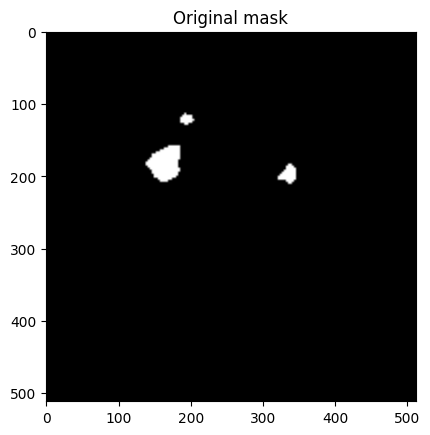

Number of pixels set to 255 before: 1862
Number of pixels set to 255 after: 3212


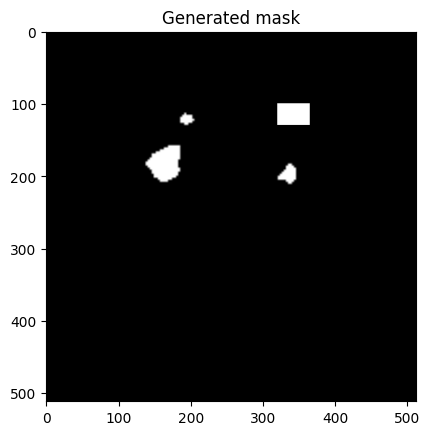

Mask generated. Size: (30, 45), position: (100, 320)
mask_image2:
  Type: <class 'PIL.Image.Image'>
  Size (width, height): (512, 512)
  Min value: 0
  Max value: 255



In [51]:
# add tot the mask_image2 another region of white pixels
print_info(mask_image2, "mask_image2")
plt.imshow(mask_image2)
plt.title("Original mask")
plt.show()


mask_size = (30, 45)
mask_position = (100, 320)

mask_image2 = transforms.ToTensor()(mask_image2)[0]
# print how many pizels are set to 255
print(f"Number of pixels set to 255 before: {torch.sum(mask_image2 == 1)}")
mask_image2[mask_position[0]:mask_position[0]+mask_size[0], mask_position[1]:mask_position[1]+mask_size[1]] = 1
print(f"Number of pixels set to 255 after: {torch.sum(mask_image2 == 1)}")
# make mask_image to three channels
mask_image2 = mask_image2[None].repeat(3, 1, 1)
mask_image2 = transforms.ToPILImage()(mask_image2)
plt.imshow(mask_image2)
plt.title("Generated mask")
plt.show()
print(f"Mask generated. Size: {mask_size}, position: {mask_position}")

print_info(mask_image2, "mask_image2")


  0%|          | 0/25 [00:00<?, ?it/s]

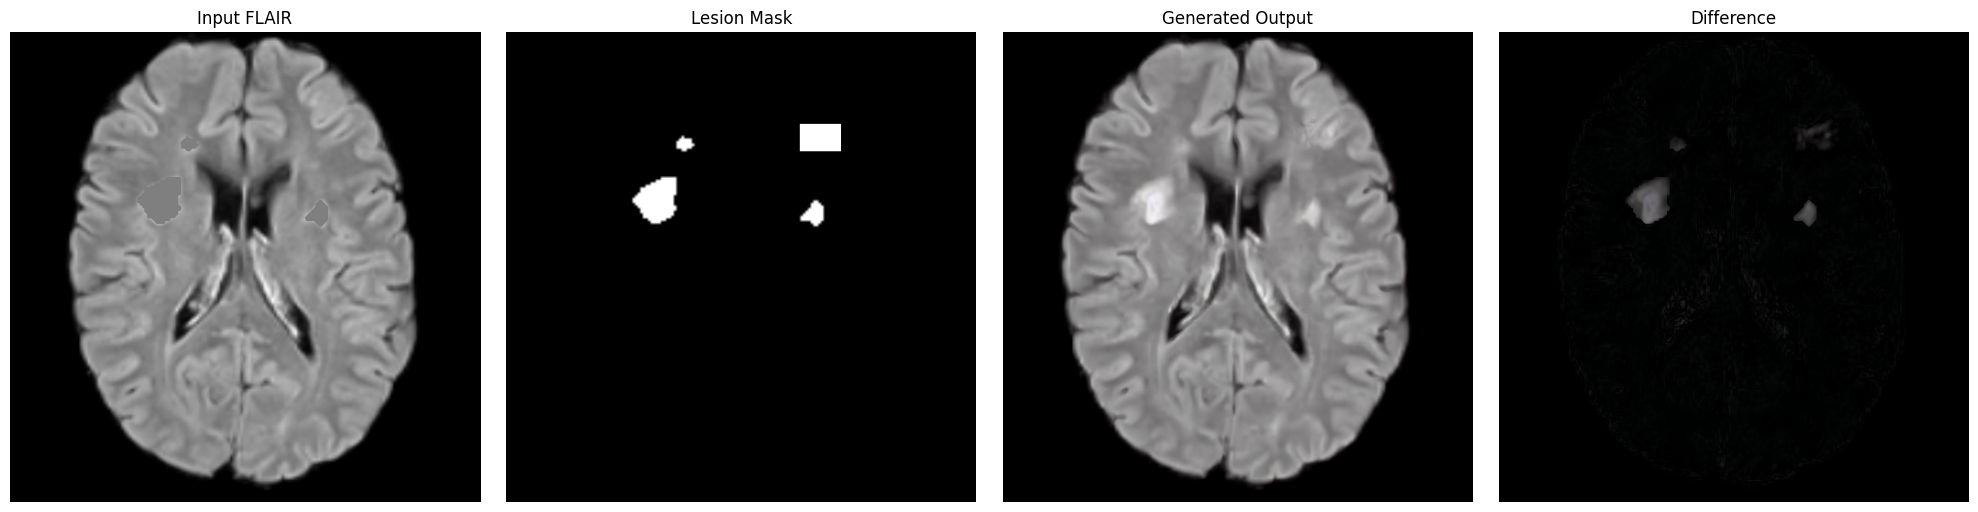

In [52]:
output_img, diff_img = generate_lesion_with_diffusion(
    pipe=pipe,
    input_image=masked_image2,
    mask_image=mask_image2,
)

  0%|          | 0/25 [00:00<?, ?it/s]

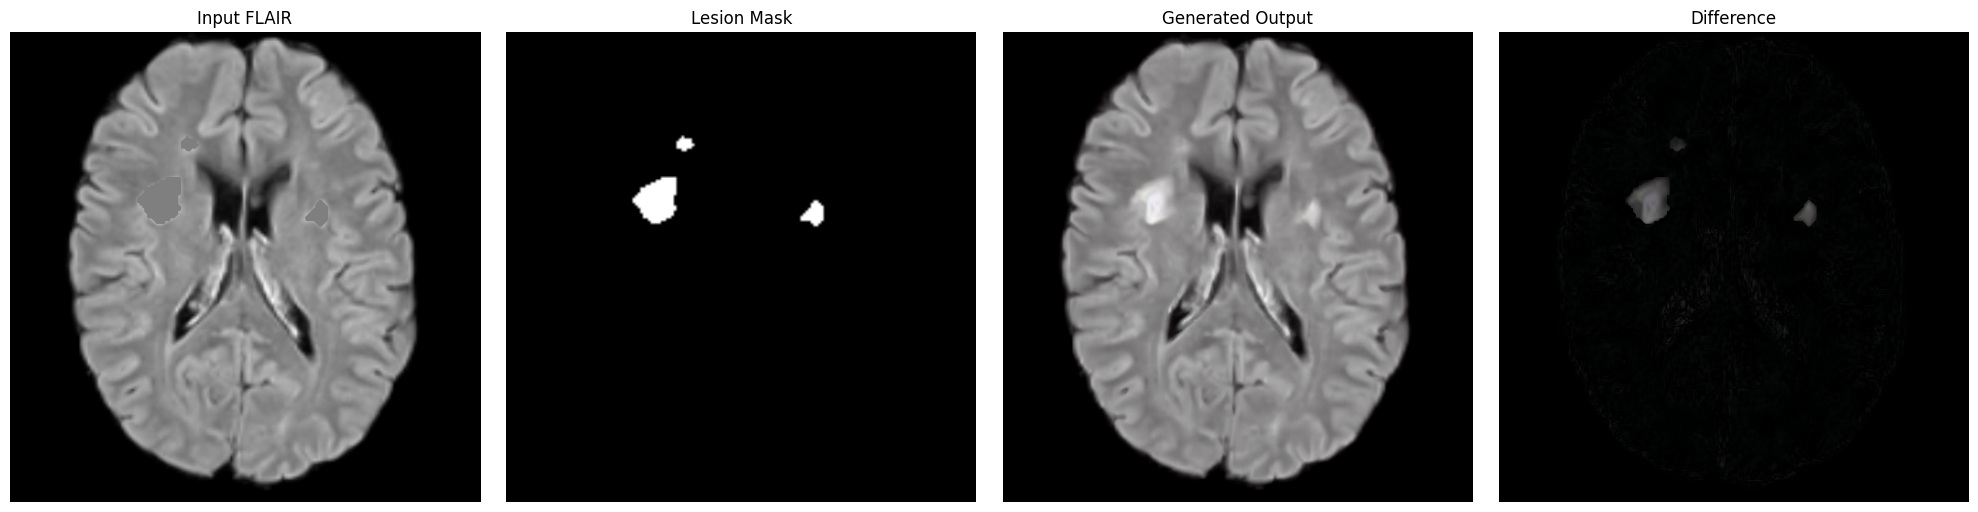

In [7]:
output_img, diff_img = generate_lesion_with_diffusion(
    pipe=pipe,
    input_image=masked_image2,
    mask_image=mask_image2,
)

  0%|          | 0/25 [00:00<?, ?it/s]

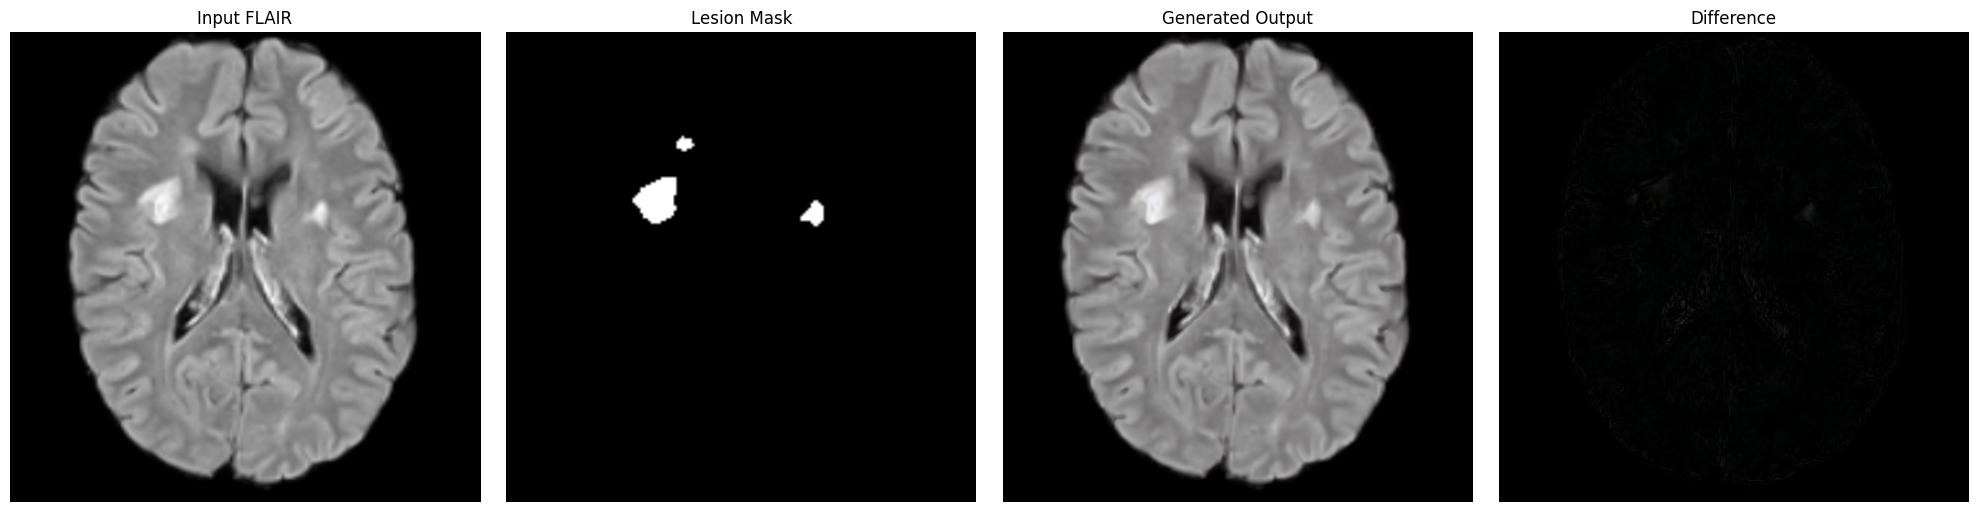

In [8]:
output_img, diff_img = generate_lesion_with_diffusion(
    pipe=pipe,
    input_image=input_image2,
    mask_image=mask_image2,
)

  0%|          | 0/25 [00:00<?, ?it/s]

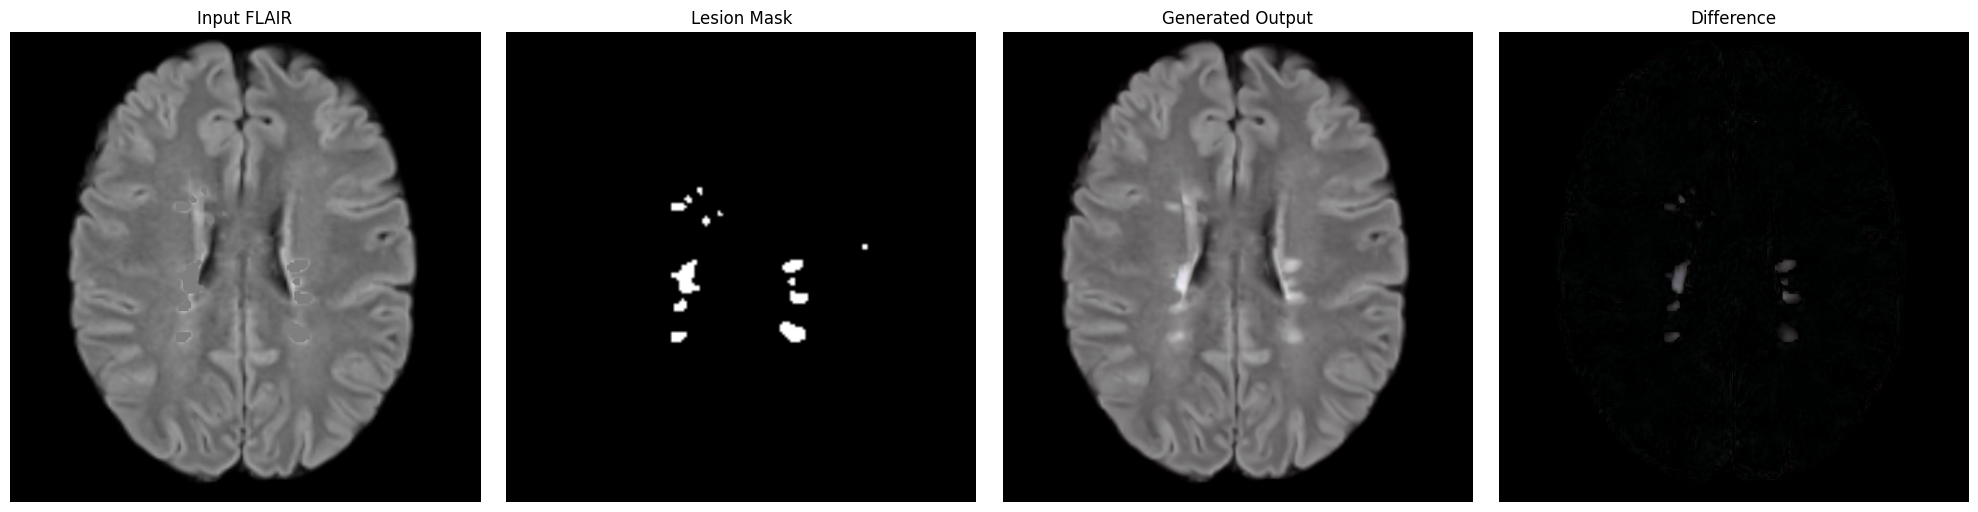

In [9]:
output_img, diff_img = generate_lesion_with_diffusion(
    pipe=pipe,
    input_image=masked_image,
    mask_image=mask_image,
)

  0%|          | 0/25 [00:00<?, ?it/s]

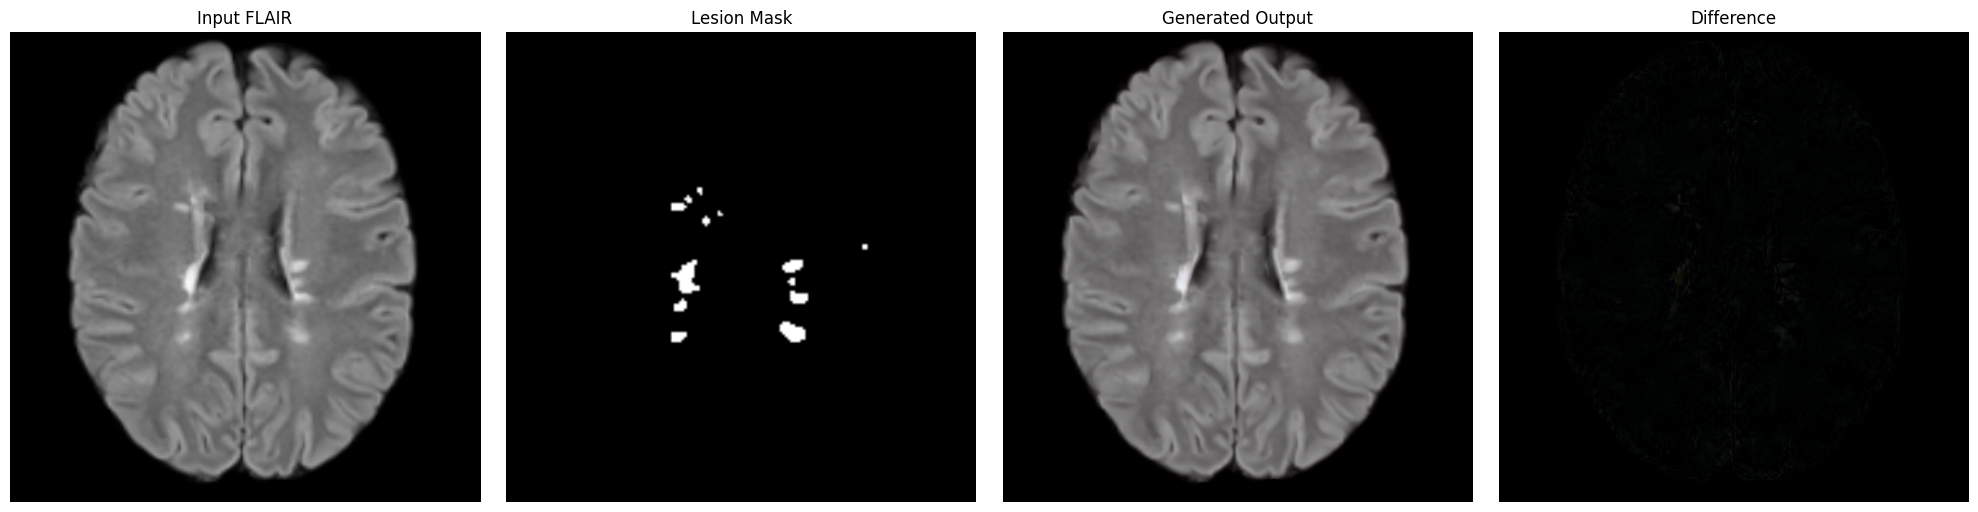

In [10]:
output_img, diff_img = generate_lesion_with_diffusion(
    pipe=pipe,
    input_image=input_image,
    mask_image=mask_image,
)

  0%|          | 0/25 [00:00<?, ?it/s]

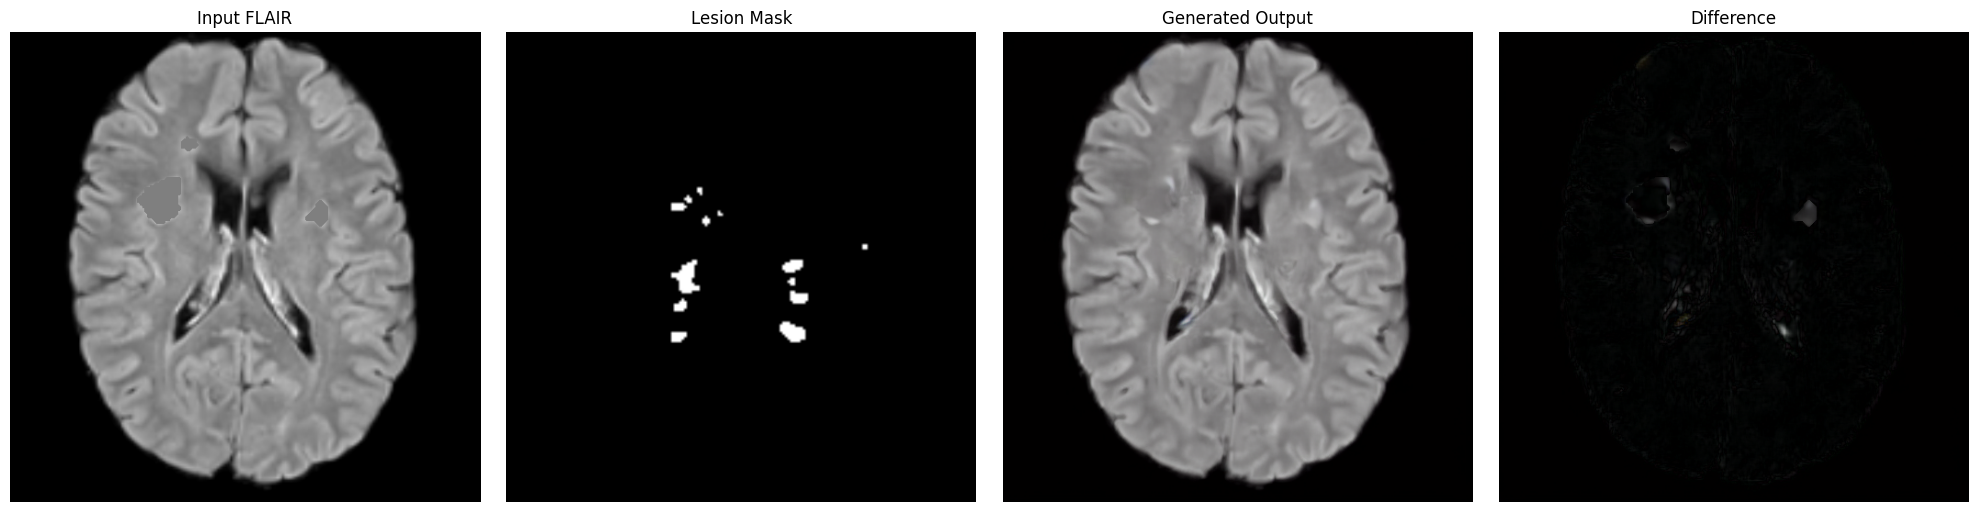

In [11]:
output_img, diff_img = generate_lesion_with_diffusion(
    pipe=pipe,
    input_image=masked_image2,
    mask_image=mask_image,
)

  0%|          | 0/25 [00:00<?, ?it/s]

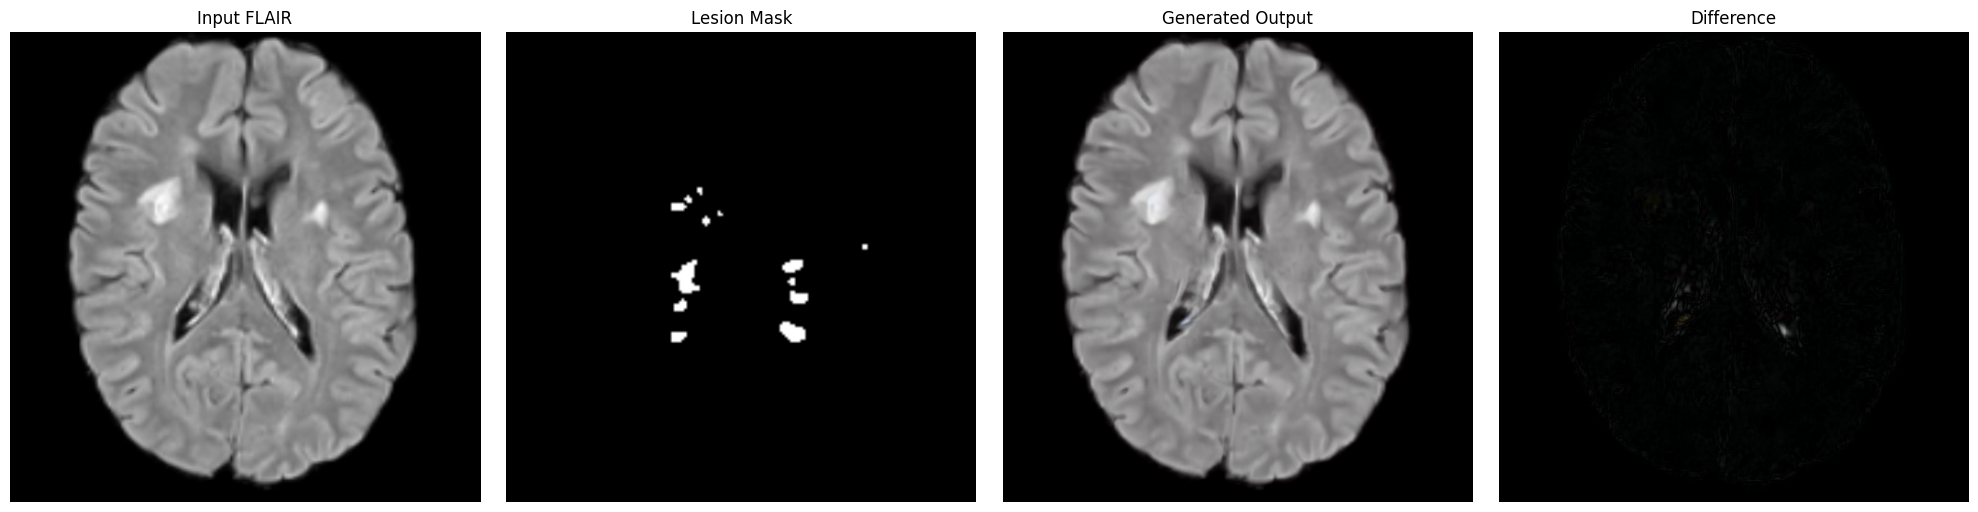

In [12]:
output_img, diff_img = generate_lesion_with_diffusion(
    pipe=pipe,
    input_image=input_image2,
    mask_image=mask_image,
)

  0%|          | 0/25 [00:00<?, ?it/s]

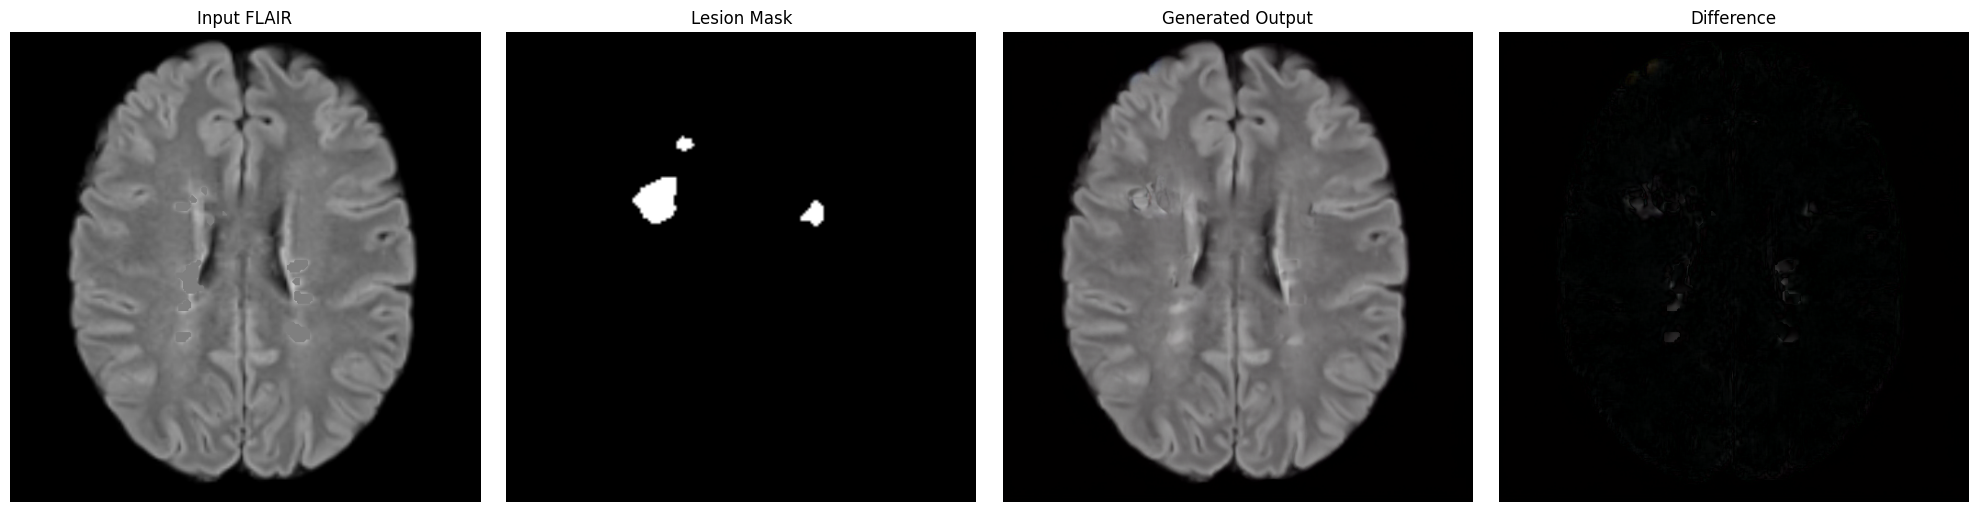

In [13]:
output_img, diff_img = generate_lesion_with_diffusion(
    pipe=pipe,
    input_image=masked_image,
    mask_image=mask_image2,
)

  0%|          | 0/25 [00:00<?, ?it/s]

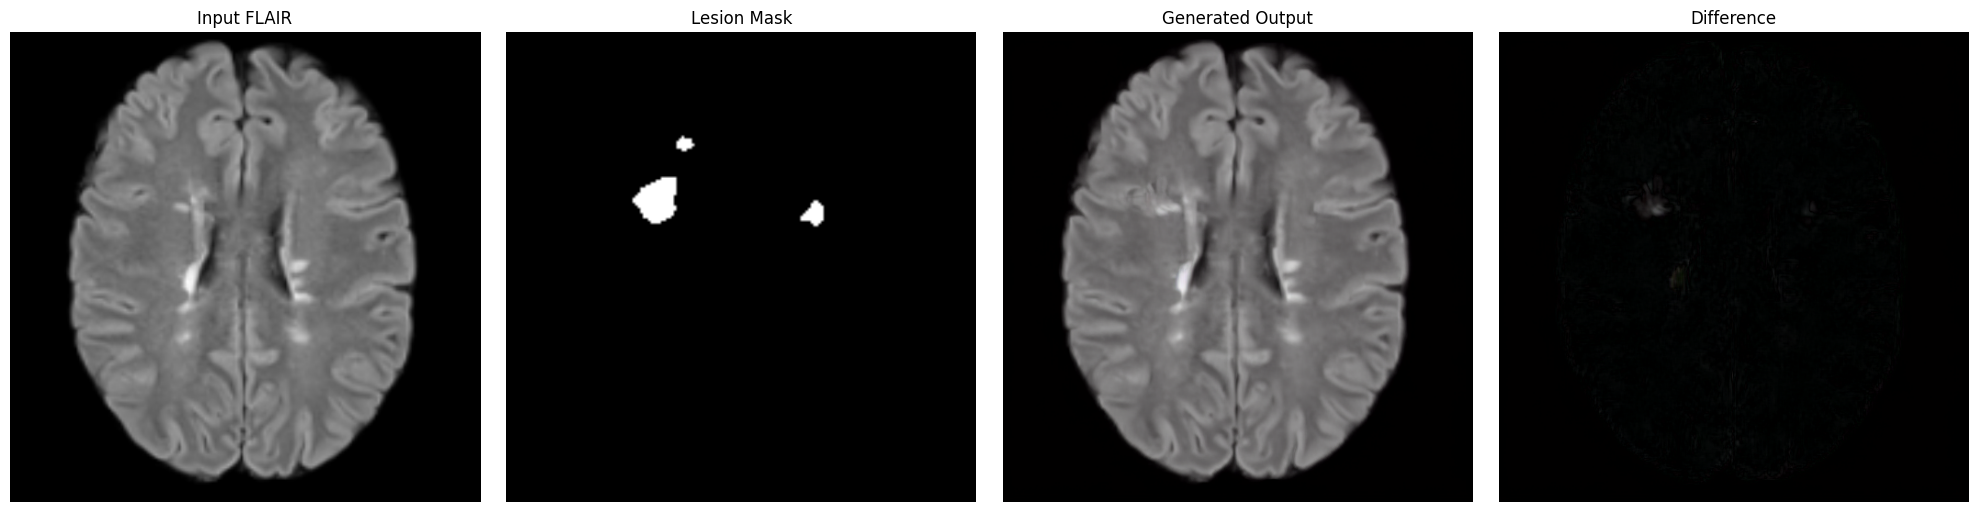

In [14]:
output_img, diff_img = generate_lesion_with_diffusion(
    pipe=pipe,
    input_image=input_image,
    mask_image=mask_image2,
)